Imports

In [ ]:
%pip install shap
import torch
import transformers
import shap

load the model: we are using InLegalLLaMA which is fine-tuned on Indian legal data

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

model_name = "sudipto-ducs/InLegalLLaMA"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype="auto", device_map="auto")

# Create a generation pipeline
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)


Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

Device set to use cuda:0


In [3]:
"""testing model on one example question"""

prompt = (
    "Q: Under Indian contract law, what are the key elements required for a contract to be considered legally binding?\n"
    "A:"
)

results = generator(prompt, max_new_tokens=150, do_sample=True, temperature=0.7)

print("Generated Response:\n")
print(results[0]["generated_text"])

Generated Response:

Q: Under Indian contract law, what are the key elements required for a contract to be considered legally binding?
A: For a contract to be binding, the following conditions must be fulfilled: (1) An offer must be made by one party to the other. (2) The offer must be accepted by the other party. (3) Both parties must reach an agreement on the terms of the contract. (4) There must be a meeting of the minds of the parties as to the main terms of the contract. (5) The parties must have a legal capacity to contract. (6) The parties must have a legal intention to enter into a contract. (7) There must be a consideration for the agreement. (8) There must be a meeting of the minds of the parties on the terms of the contract. (9) The parties must


load and test out dataset of past Indian legal cases which are labeled based on result


In [4]:
from datasets import load_dataset

# Load the Realistic_LJP_CaseSummarizer dataset
dataset = load_dataset("L-NLProc/Realistic_LJP_CaseSummarizer", split="train")


README.md:   0%|          | 0.00/31.0 [00:00<?, ?B/s]

Realistic_LJP_CaseSummarizer.csv:   0%|          | 0.00/140M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/33336 [00:00<?, ? examples/s]

In [6]:
from tqdm import tqdm

def predict(summary, max_tokens=80):
    prompt = f"Case summary: {summary}\nWhat was the judgment?"
    try:
        output = generator(prompt, max_new_tokens=max_tokens, do_sample=True, temperature=0.7)[0]["generated_text"]
        return output[len(prompt):].strip()
    except Exception as e:
        return f"ERROR: {str(e)}"

# Run predictions
summaries = dataset["text"]
ground_truth = dataset["label"]
  

batched_predictions = []

batch_size = 4
batched_summaries = [summaries[i:i+batch_size] for i in range(0, len(summaries), batch_size)]

for batch in tqdm(batched_summaries[:25]):
    prompts = [f"Case summary: {s}\nWhat was the judgment?" for s in batch]
    outputs = generator(prompts, max_new_tokens=80, do_sample=True, temperature=0.7)
    batch_preds = [out[0]["generated_text"].split("What was the judgment?")[-1].strip() for out in outputs]
    batched_predictions.extend(batch_preds)

# note that the model will generate a bunch of reasoning for the case as an LLM and not a discrete label like 0 or 1 which 
# is what the dataset uses instead, so we can't really use the ground truth labels


100%|██████████| 25/25 [05:54<00:00, 14.17s/it]


In [7]:
# preview predictions

import pandas as pd

df = pd.DataFrame({
    "summary": summaries[:100],
    "ground_truth": ground_truth[:100],
    "predicted_judgment": batched_predictions
})

# Display sample
print(df.head())

# Save to file
df.to_csv("inlegal_predictions_realisticLJP.csv", index=False)


                                             summary  ground_truth  \
0  63 of 1971. Niren De, Attorney. 196 of 1971. N...             0   
1  516 of 1983. 692 of 1983. The grounds of deten...             1   
2  Heard the learned companynsel for the parties....             1   
3  Further, direction was sought to the appellant...             0   
4  These banks are hereinafter referred to as the...             0   

                                  predicted_judgment  
0  The appellant had challenged the validity of t...  
1  The grounds of detention were served on the re...  
2  2. The respondent herein, was a tenant in the ...  
3  A Division Bench of the High Court of Punjab a...  
4  The petitioners contend that the Ordinance is ...  


In [8]:
for i, row in df.iterrows():
    print(f"Summary #{i+1}:\n{row['summary'][:300]}...\n")
    print(f"Ground Truth: {row['ground_truth']}")
    print(f"Model Prediction: {row['predicted_judgment']}\n")
    print("-" * 80)
    if i >= 4:  # Show top 5
        break


Summary #1:
63 of 1971. Niren De, Attorney. 196 of 1971. Niren De, Attorney General, Ram Panjwani, R. H. Dhebar and P. Nayar, for the Union of India. General, R. H. Dhebar, Ram Panjwani, B. Dadachanji, 0. 63 of 1971 filed by U. N. R. Rao, appellant before us. C. Mathur and Ravinder Narain, for the respondent. I...

Ground Truth: 0
Model Prediction: The appellant had challenged the validity of the appointment of the respondent as a Judge of the Madras High Court. The appellant contended that the respondent was not qualified to be appointed as a Judge of the High Court as he had no experience of judicial work. He had only been a member of the Bar for 14 years. It was pointed out that

--------------------------------------------------------------------------------
Summary #2:
516 of 1983. 692 of 1983. The grounds of detention were served on the respondent on October 6, 1983. Those grounds show that the petitioner was detained on the basis of two speeches allegedly made by him one on July

code segment only if the model can predict in a binary fashion (comparing to ground truth)

In [ ]:
def predict_binary(summary, max_tokens=5):
    prompt = (
        f"Case summary: {summary}\n"
        "Based on the above summary, is the outcome a conviction (1) or not (0)?\n"
        "Answer with only 0 or 1.\n"
    )
    try:
        output = generator(prompt, max_new_tokens=max_tokens, do_sample=False)[0]["generated_text"]
        answer = output.strip().split()[-1]  # get last word (0 or 1)
        return int(answer) if answer in ["0", "1"] else -1  # fallback
    except:
        return -1


In [11]:
batched_predictions = []

batch_size = 4
batched_summaries = [summaries[i:i+batch_size] for i in range(0, len(summaries), batch_size)]

for batch in tqdm(batched_summaries[:25]):
    prompts = [f"Case summary: {s}\n"
        "Based on the above summary, is the outcome a conviction (1) or not (0)?\n"
        "Answer with only 0 or 1.\n" for s in batch]
    outputs = generator(prompts, max_new_tokens=80, do_sample=True, temperature=0.7)
    batch_preds = [out[0]["generated_text"].split("What was the judgment?")[-1].strip() for out in outputs]
    batched_predictions.extend(batch_preds)


100%|██████████| 25/25 [06:00<00:00, 14.42s/it]


In [12]:
for i, (summary, pred) in enumerate(zip(summaries[:len(batched_predictions)], batched_predictions)):
    print(f"\nSummary {i + 1}: {summary}")
    print(f"Prediction: {pred}")



Summary 1: 63 of 1971. Niren De, Attorney. 196 of 1971. Niren De, Attorney General, Ram Panjwani, R. H. Dhebar and P. Nayar, for the Union of India. General, R. H. Dhebar, Ram Panjwani, B. Dadachanji, 0. 63 of 1971 filed by U. N. R. Rao, appellant before us. C. Mathur and Ravinder Narain, for the respondent. In this petition the appellant had prayed that a writ of qua warranto be issued to the respondent, Smt. Appeal from the judgment and order dated January 21, and February 5, 1971 of the Madras High Court in Writ Petition No. The Judgment of the Court was delivered by Sikri, C. J, This appeal by certificate is directed against the judgment of the High Court of, Judgment Madras dismissing Writ Petition No. The appellant appeared in person. CIVIL APPELLATE JURISDICTION Civil Appeal No. 
Prediction: Case summary: 63 of 1971. Niren De, Attorney. 196 of 1971. Niren De, Attorney General, Ram Panjwani, R. H. Dhebar and P. Nayar, for the Union of India. General, R. H. Dhebar, Ram Panjwani, 

## Applying SHAP
see how much each part of the prompt text contributes to the token probability of "granted"

In [27]:
target_token = "arrest"

In [28]:
def predict_prob_granted(texts):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True).to(model.device)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.softmax(outputs.logits[0, -1], dim=0)
        token_id = tokenizer.encode(target_token, add_special_tokens=False)[0]
        results.append(probs[token_id].item())
    return np.array(results).reshape(-1, 1)


In [29]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Load dataset ---
dataset = load_dataset("L-NLProc/Realistic_LJP_CaseSummarizer", split="train[:100]")  # start with 100 for speed
summaries = [sample["text"] for sample in dataset]

# --- Define SHAP-friendly prediction function ---
def predict_prob_granted(texts):
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.softmax(outputs.logits[0, -1], dim=-1)  # last token
        target_id = tokenizer.encode(target_token, add_special_tokens=False)[0]
        results.append(probs[target_id].item())
    return torch.tensor(results).unsqueeze(1).cpu().numpy()

# --- Run SHAP ---
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_prob_granted, masker=masker, algorithm="partition")

# Choose 3 sample summaries for demo
sample_texts = summaries[:3]
shap_values = explainer(sample_texts)

# --- Visualize ---
for i in range(len(sample_texts)):
    print(f"\nSHAP for Case {i+1}:")
    shap.plots.text(shap_values[i])


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [01:09<00:00, 24.29s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:21, 27.19s/it]                       


SHAP for Case 1:



SHAP for Case 2:



SHAP for Case 3:


sample prediction with SHAP

In [26]:
print(shap_values[0].values)      # SHAP values per token
print(shap_values[0].data)        # Raw tokens
print(shap_values[0].base_values) # Model prediction for the baseline (null input)

[[-3.92362937e-08]
 [-3.32773630e-06]
 [-1.71002899e-06]
 [-1.71096032e-06]
 [-3.92739734e-07]
 [-3.92739734e-07]
 [-1.32289816e-06]
 [-1.32150117e-06]
 [-8.66239653e-07]
 [-8.63911346e-07]
 [-1.68976164e-06]
 [-7.94286316e-07]
 [-7.82644784e-07]
 [-1.09766464e-06]
 [-1.83542734e-06]
 [-1.86988628e-06]
 [-1.81484512e-06]
 [-1.67607805e-06]
 [-3.48191252e-06]
 [-9.05525434e-07]
 [-2.19540720e-06]
 [-1.64080461e-06]
 [-1.64452990e-06]
 [-4.18975912e-07]
 [-4.18975912e-07]
 [-1.34913433e-06]
 [-1.34773735e-06]
 [-8.92475831e-07]
 [-8.90147524e-07]
 [-1.71599782e-06]
 [-5.29551009e-07]
 [-5.29551009e-07]
 [-5.29551009e-07]
 [-1.00149872e-06]
 [-1.01872819e-06]
 [-6.69660729e-07]
 [-6.69660729e-07]
 [-1.09515873e-06]
 [-1.78720901e-06]
 [-6.63692504e-07]
 [-6.97997393e-08]
 [-6.97997393e-08]
 [-6.97997393e-08]
 [-6.97997393e-08]
 [-1.73326991e-06]
 [-1.34599494e-06]
 [-1.47824275e-06]
 [-3.05365175e-06]
 [-3.38892788e-06]
 [-1.21483294e-06]
 [-4.57925085e-09]
 [-1.61413749e-06]
 [-7.0066526

In [27]:
import shap
masker = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(predict_prob_granted, masker=masker, algorithm="partition")
shap_values_clean = explainer(["In the matter of the petitioner...", "The court considered the appeal..."])
shap.plots.text(shap_values_clean[0])

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


## Adding noise and attacks
perturbing the prompt to see how well SHAP will do

In [30]:
import random

def add_gaussian_noise(text, std=0.1):
    words = text.split()
    noised_words = []
    for word in words:
        if random.random() < std:
            # Insert slight typo / perturbation
            if len(word) > 3:
                idx = random.randint(1, len(word)-2)
                word = word[:idx] + random.choice('abcdefghijklmnopqrstuvwxyz') + word[idx+1:]
        noised_words.append(word)
    return " ".join(noised_words)


In [31]:
def simulate_token_attack(text, attack_words=None):
    """Replace legal phrases or keywords with confusing/neutral terms"""
    if attack_words is None:
        attack_words = {
            "granted": "considered",
            "dismissed": "reviewed",
            "petition": "application",
            "plaintiff": "person",
            "court": "panel",
            "appeal": "request",
        }
    for key, val in attack_words.items():
        text = text.replace(key, val)
    return text

In [32]:
original_texts = summaries[:3]  # small batch
gaussian_texts = [add_gaussian_noise(t) for t in original_texts]
attacked_texts = [simulate_token_attack(t) for t in original_texts]

# Run SHAP
shap_orig = explainer(original_texts)
shap_noise = explainer(gaussian_texts)
shap_attack = explainer(attacked_texts)


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [01:10<00:00, 24.53s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:22, 27.45s/it]                       


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [01:11<00:00, 24.82s/it]

  0%|          | 0/240 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:21, 27.31s/it]                       


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 1/3 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 100%|██████████| 3/3 [01:09<00:00, 24.38s/it]

  0%|          | 0/272 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [01:21, 27.14s/it]                       


In [35]:
import numpy as np

def compare_shap_drift(shap1, shap2):
    diffs = []
    for s1, s2 in zip(shap1, shap2):
        v1 = np.array(s1.values)
        v2 = np.array(s2.values)
        min_len = min(len(v1), len(v2))
        v1 = v1[:min_len]
        v2 = v2[:min_len]
        diffs.append(np.abs(v1 - v2).mean())
    return np.mean(diffs)


print("L1 diff (Original vs Gaussian):", compare_shap_drift(shap_orig, shap_noise))
print("L1 diff (Original vs FGSM-simulated):", compare_shap_drift(shap_orig, shap_attack))


L1 diff (Original vs Gaussian): 0.0006312727911280114
L1 diff (Original vs FGSM-simulated): 0.00027185206390396534


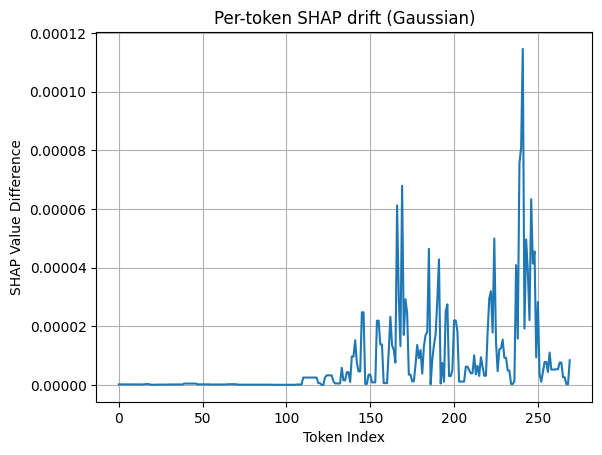

In [37]:
import matplotlib.pyplot as plt

min_len = min(len(shap_orig[0].values), len(shap_noise[0].values))
plt.plot(np.abs(np.array(shap_orig[0].values[:min_len]) - np.array(shap_noise[0].values[:min_len])))
plt.title("Per-token SHAP drift (Gaussian)")
plt.xlabel("Token Index")
plt.ylabel("SHAP Value Difference")
plt.grid(True)
plt.show()


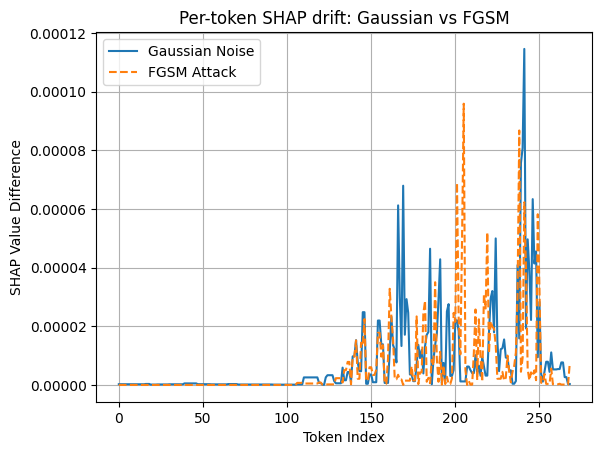

In [38]:
min_len = min(len(shap_orig[0].values), len(shap_noise[0].values), len(shap_attack[0].values))
plt.plot(np.abs(np.array(shap_orig[0].values[:min_len]) - np.array(shap_noise[0].values[:min_len])), label="Gaussian Noise")
plt.plot(np.abs(np.array(shap_orig[0].values[:min_len]) - np.array(shap_attack[0].values[:min_len])), label="FGSM Attack", linestyle="--")
plt.title("Per-token SHAP drift: Gaussian vs FGSM")
plt.xlabel("Token Index")
plt.ylabel("SHAP Value Difference")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
shap.plots.text(shap_orig[0], display=False)
shap.plots.text(shap_noise[0], display=False)
shap.plots.text(shap_attack[0], display=True)


Memory Management

In [40]:
import gc
gc.collect()
torch.cuda.empty_cache()